# 基礎集計

In [213]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [214]:
class CFG:
  exp = "exp03"
  seed = 71
  fold = 5

CONFIG = CFG()

In [215]:
input_dir = "../data/"
output_dir = "../submit/"

In [216]:
pd.set_option("display.max_colwidth", 50)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

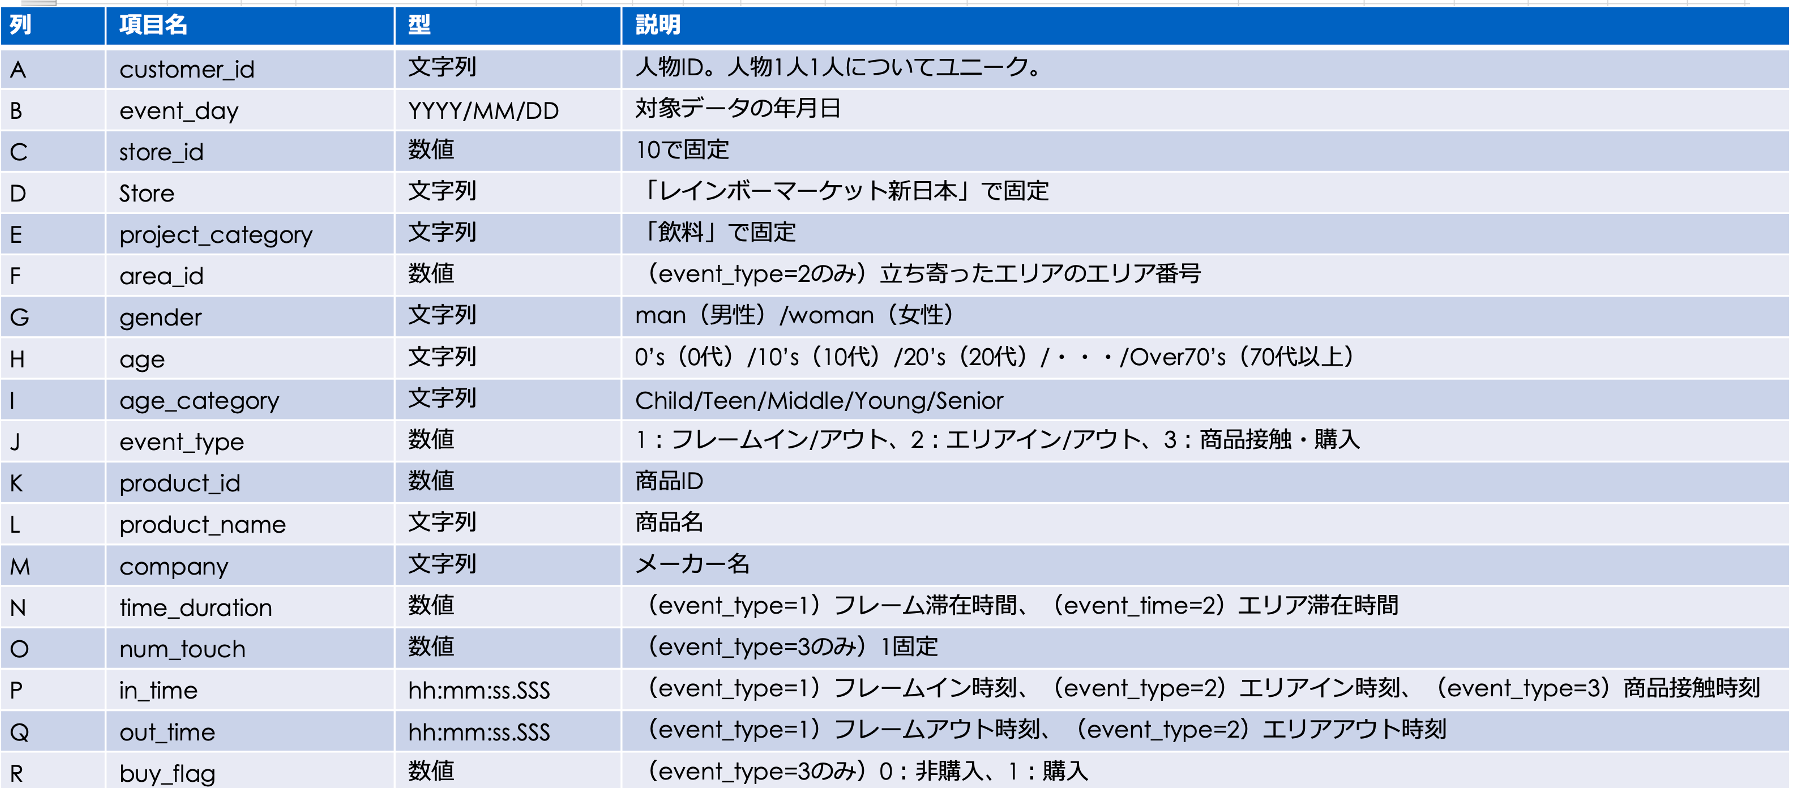

In [217]:
Image(input_dir + "description.png", width = 1000)

In [218]:
df_train.describe()

,store_id,area_id,event_type,product_id,time_duration,num_touch,buy_flag
count,20317.0,6480.000000,20317.000000,7042.000000,20277.000000,7042.000000,7002.000000
mean,10.0,2.637500,2.012157,50.432548,18.180658,0.994320,0.741074
std,0.0,1.439391,0.825191,39.172571,28.341374,0.075158,0.438076
min,10.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10.0,1.000000,1.000000,17.000000,0.000000,1.000000,0.000000
50%,10.0,3.000000,2.000000,41.000000,9.200000,1.000000,1.000000
75%,10.0,4.000000,3.000000,83.000000,23.600000,1.000000,1.000000
max,10.0,5.000000,3.000000,138.000000,421.600000,1.000000,1.000000


In [219]:
df_train.head()

,customer_id,event_day,store_id,store,project_category,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
0,20201026-010001,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,1,NaN,NaN,NaN,6.2,NaN,08:01:50.200,08:01:56.400,NaN
1,20201026-010002,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,13.6,NaN,08:02:43.600,08:02:57.200,NaN
2,20201026-010003,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,14.2,NaN,08:02:57.800,08:03:12.000,NaN
3,20201026-010004,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,10's,Teen,1,NaN,NaN,NaN,21.0,NaN,08:06:13.200,08:06:34.200,NaN
4,20201026-010005,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,30's,Young,1,NaN,NaN,NaN,19.2,NaN,08:07:06.000,08:07:25.200,NaN


In [220]:
df_train.shape

(20317, 18)

In [221]:
df_train.customer_id.nunique()

6795

In [222]:
df_test.describe()

,store_id,area_id,event_type,product_id,time_duration,num_touch
count,13200.0,4248.000000,13200.000000,4422.000000,13200.000000,4422.0
mean,10.0,2.653955,1.991818,50.226820,18.272773,1.0
std,0.0,1.417815,0.823509,38.517094,27.951171,0.0
min,10.0,1.000000,1.000000,1.000000,0.000000,1.0
25%,10.0,1.000000,1.000000,18.000000,0.000000,1.0
50%,10.0,3.000000,2.000000,42.000000,9.300000,1.0
75%,10.0,4.000000,3.000000,82.000000,23.800000,1.0
max,10.0,5.000000,3.000000,136.000000,370.200000,1.0


In [223]:
df_test.head()

,customer_id,event_day,store_id,store,project_category,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time
0,20201026-010006,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,40's,Middle,1,NaN,NaN,NaN,19.8,NaN,08:07:13.000,08:07:32.800
1,20201026-010008,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,40's,Middle,1,NaN,NaN,NaN,21.2,NaN,08:10:32.600,08:10:53.800
2,20201026-010011,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,50's,Middle,1,NaN,NaN,NaN,19.4,NaN,08:11:34.400,08:11:53.800
3,20201026-010012,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,woman,20's,Young,1,NaN,NaN,NaN,15.2,NaN,08:12:40.600,08:12:55.800
4,20201026-010018,2020/10/26,10,レインボーマーケット新日本,飲料,NaN,man,10's,Teen,1,NaN,NaN,NaN,23.0,NaN,08:19:33.000,08:19:56.000


In [224]:
df_test.shape

(13200, 17)

In [225]:
df_test.customer_id.nunique()

4530

In [226]:
sample_submit

,customer_id,buy_proba
0,20201026-010006,0.5
1,20201026-010008,0.5
2,20201026-010011,0.5
3,20201026-010012,0.5
4,20201026-010018,0.5
...,...,...
4525,20201101-120039,0.5
4526,20201101-120046,0.5
4527,20201101-120051,0.5
4528,20201101-120052,0.5


In [227]:
sample_submit.shape

(4530, 2)

## Null check

<AxesSubplot:>

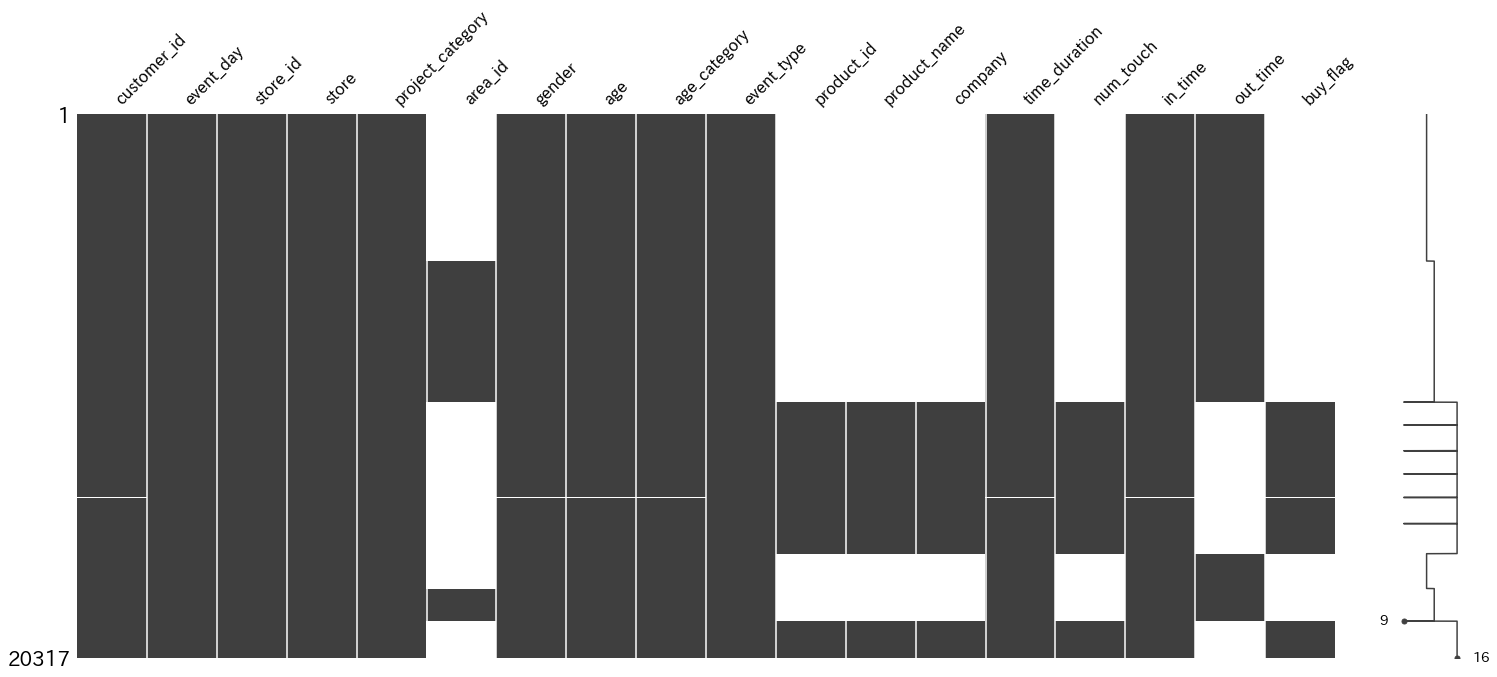

In [228]:
## Train data
msno.matrix(df_train)

<AxesSubplot:>

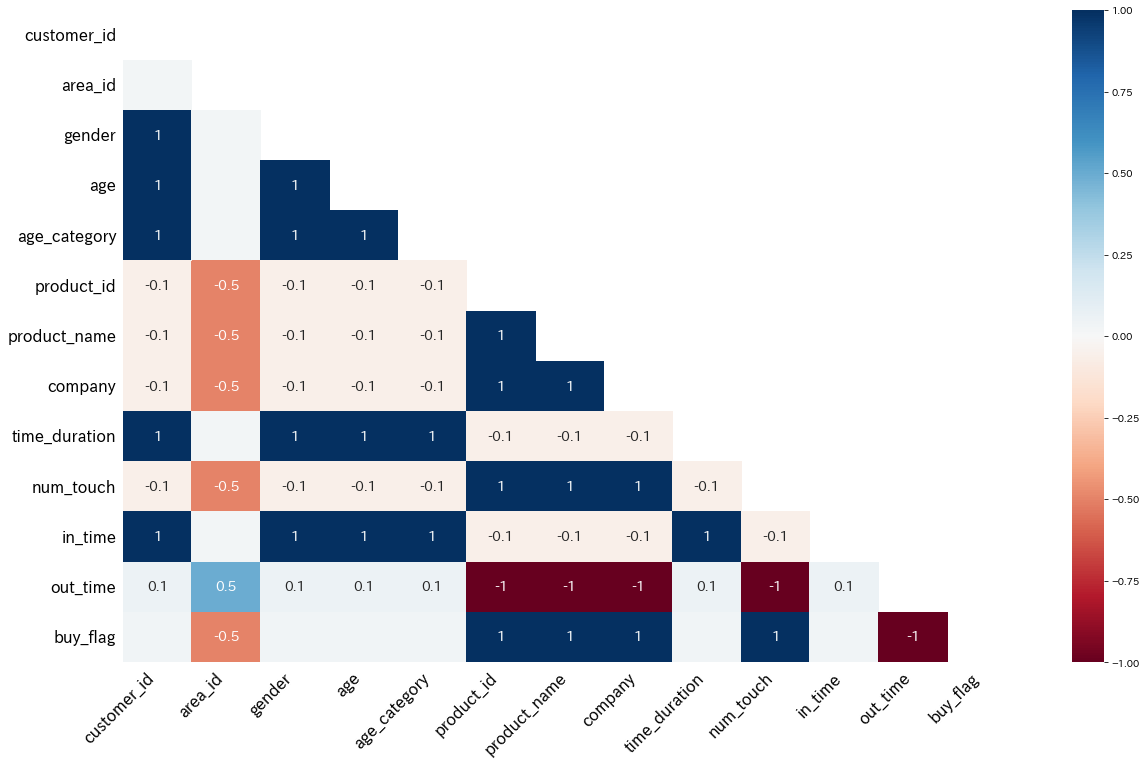

In [229]:
msno.heatmap(df_train)

<AxesSubplot:>

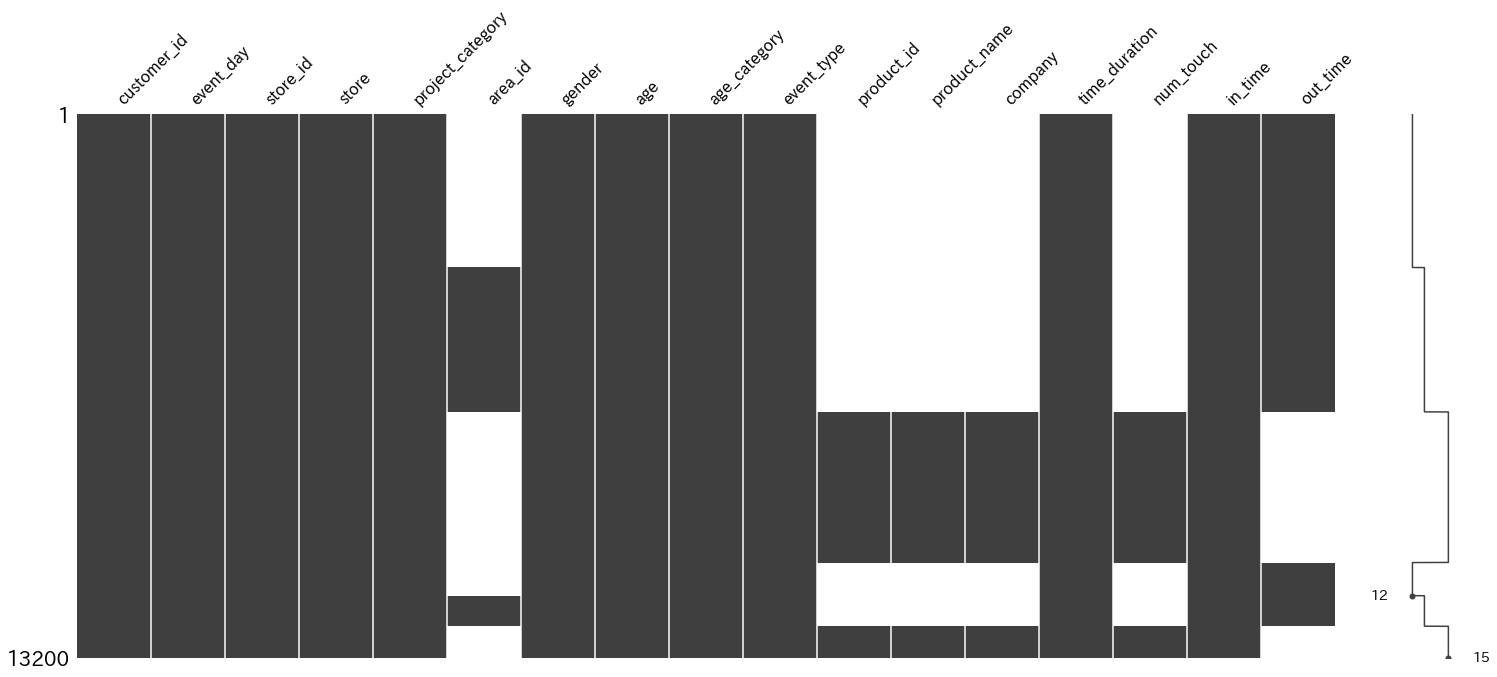

In [230]:
#test data
msno.matrix(df_test)

<AxesSubplot:>

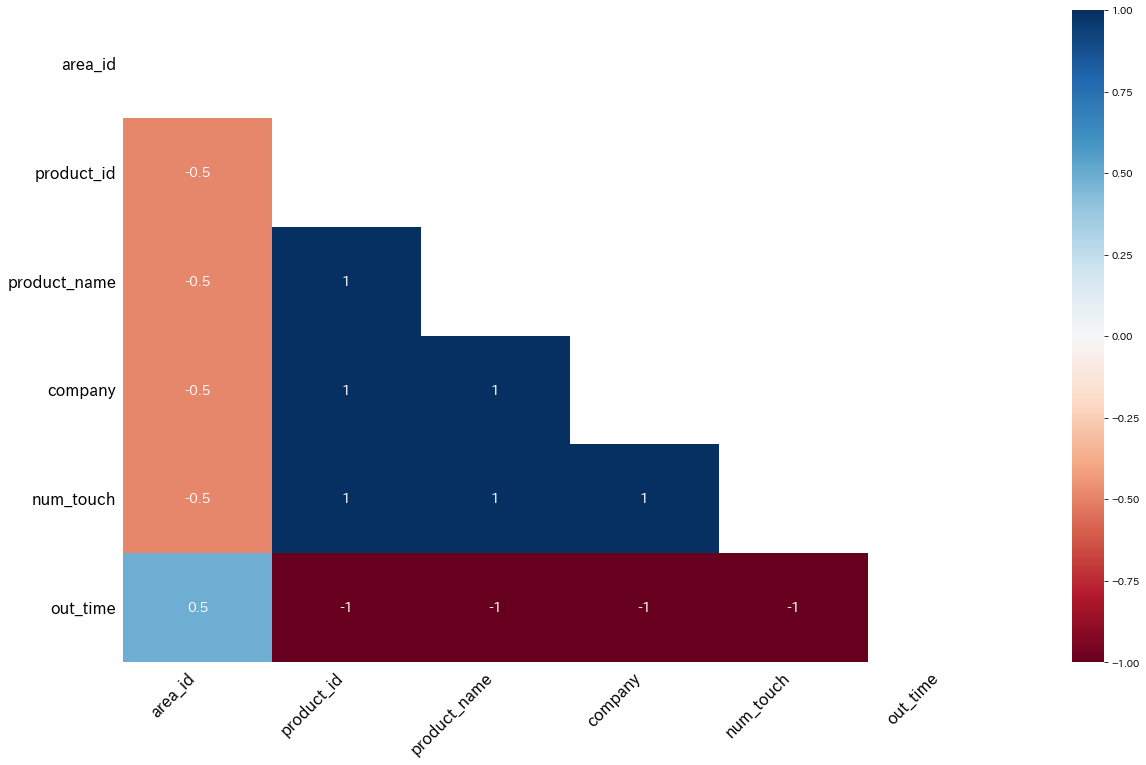

In [231]:
msno.heatmap(df_test)

In [232]:
df_train = df_train[~df_train.customer_id.isnull()].reset_index()

## 特徴量カテゴリーの確認

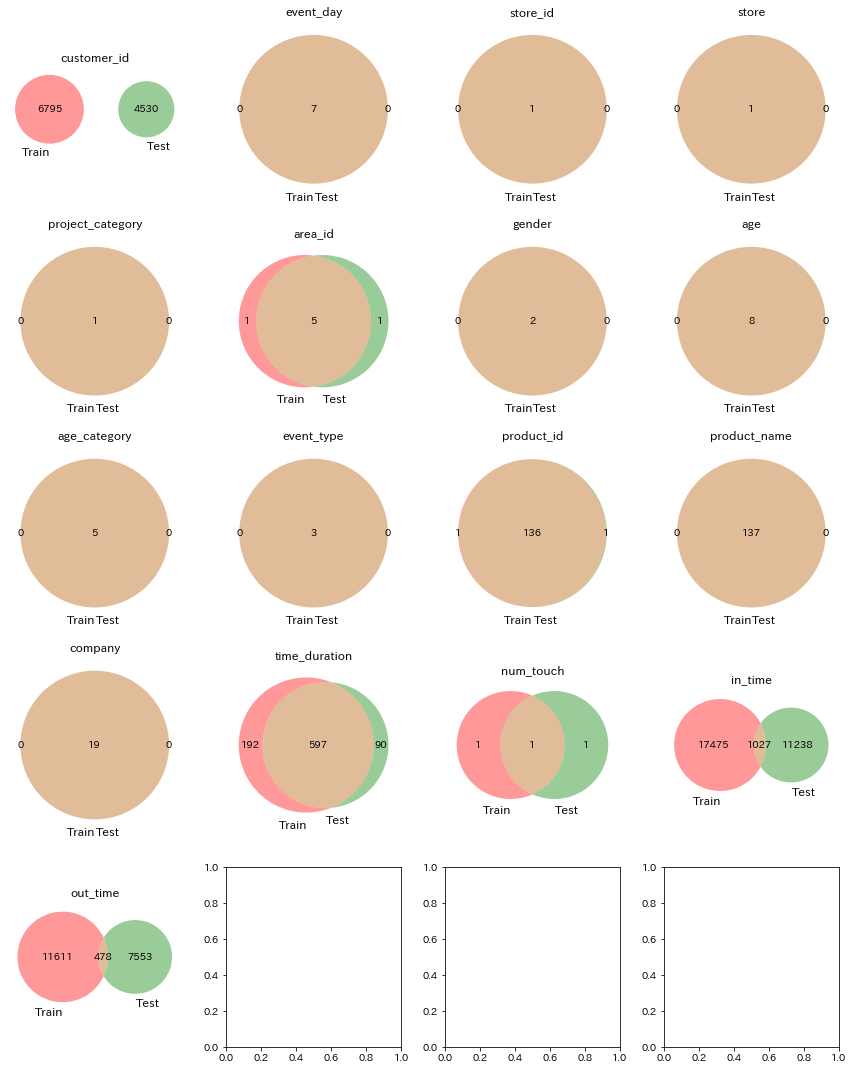

In [233]:
#目的変数を除くベン図の作成
columns = df_test.columns
columns_num = len(columns)
n_cols = 4
n_rows = columns_num // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols*3, n_rows*3),
                         ncols=n_cols, nrows=n_rows)

for col, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(df_train[col].unique()), set(df_test[col].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(col)
    
fig.tight_layout()

# データフレームの形状変更（予測用に変換）

In [234]:
df_train = df_train[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch', 
                     'in_time',
                     'out_time', 
                     'buy_flag']]

df_test = df_test[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch',
                     'in_time',
                     'out_time']]

## データフレームの区分け

In [235]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [236]:
#shopper属性
df_shopper_train=df_train[["customer_id","gender","age","age_category"]].drop_duplicates().set_index("customer_id")
df_shopper_test=df_test[["customer_id","gender","age","age_category"]].drop_duplicates().set_index("customer_id")

#shopper接触回数（合計）
df_contact_train = df_train.groupby("customer_id")[["num_touch"]].sum().astype(int)
df_contact_test = df_test.groupby("customer_id")[["num_touch"]].sum().astype(int)

#shopper area id
df_area_train=pd.crosstab(df_train2.customer_id,df_train2.area_id).fillna(0).astype(int)
df_area_train.columns=["area_1","area_2","area_3","area_4","area_5"]
df_area_test=pd.crosstab(df_test2.customer_id,df_test2.area_id).fillna(0).astype(int)
df_area_test.columns=["area_1","area_2","area_3","area_4","area_5"]

#shpper area time
df_areatime_train=pd.pivot_table(df_train2,index="customer_id",columns="area_id",values="time_duration").fillna(0)
df_areatime_train.columns=["area_time_1","area_time_2","area_time_3","area_time_4","area_time_5"]
df_areatime_test=pd.pivot_table(df_test2,index="customer_id",columns="area_id",values="time_duration").fillna(0)
df_areatime_test.columns=["area_time_1","area_time_2","area_time_3","area_time_4","area_time_5"]

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates().set_index("customer_id")
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates().set_index("customer_id")

#shopper_touch_items
df_touch_item_train=df_train[df_train.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_train=pd.crosstab(df_touch_item_train.customer_id,df_touch_item_train.product_name).astype(int)
df_touch_item_test=df_test[df_test.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_test=pd.crosstab(df_touch_item_test.customer_id,df_touch_item_test.product_name).astype(int)

#shopper_touch_items_company
df_touch_item_comp_train=df_train[df_train.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_comp_train=pd.crosstab(df_touch_item_comp_train.customer_id,df_touch_item_comp_train.company).astype(int)
df_touch_item_comp_test=df_test[df_test.num_touch > 0][["customer_id","product_name","product_id","company"]]
df_touch_item_comp_test=pd.crosstab(df_touch_item_comp_test.customer_id,df_touch_item_comp_test.company).astype(int)

#shopper購入回数(合計）
df_buy_train = df_train.groupby("customer_id")[["buy_flag"]].sum().astype(int)


In [237]:
df_train = pd.concat([df_shopper_train, 
                      df_contact_train,
                      df_area_train,
                      df_areatime_train,
                      df_frametime_train,
                      df_touch_item_train,
                      #df_touch_item_comp_train,
                      df_buy_train],
                      axis=1)

df_train = df_train.fillna(0).reset_index()

df_test = pd.concat([df_shopper_test, 
                      df_contact_test,
                      df_area_test,
                      df_areatime_test,
                      df_frametime_test,
                      df_touch_item_test],
                      #df_touch_item_comp_test],
                      axis=1)

df_test = df_test.fillna(0).reset_index()


In [238]:
df_train

,customer_id,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,...,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,buy_flag
0,20201026-010001,woman,30's,Young,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,20201026-010002,man,50's,Middle,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,20201026-010003,man,50's,Middle,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,20201026-010004,man,10's,Teen,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,20201026-010005,woman,30's,Young,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,20201101-120050,man,30's,Young,4,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
6791,20201101-120053,man,30's,Young,11,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
6792,20201101-120054,man,30's,Young,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6793,20201101-120055,woman,30's,Young,2,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [239]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Columns: 154 entries, customer_id to buy_flag
dtypes: float64(147), int64(2), object(5)
memory usage: 8.0+ MB


In [240]:
df_train

,customer_id,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,...,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,buy_flag
0,20201026-010001,woman,30's,Young,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,20201026-010002,man,50's,Middle,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,20201026-010003,man,50's,Middle,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,20201026-010004,man,10's,Teen,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,20201026-010005,woman,30's,Young,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,20201101-120050,man,30's,Young,4,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
6791,20201101-120053,man,30's,Young,11,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
6792,20201101-120054,man,30's,Young,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6793,20201101-120055,woman,30's,Young,2,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [241]:
df_test

,customer_id,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,...,花の癒し500ml,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml
0,20201026-010006,man,40's,Middle,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20201026-010008,man,40's,Middle,3,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20201026-010011,man,50's,Middle,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,20201026-010012,woman,20's,Young,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20201026-010018,man,10's,Teen,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4525,20201101-120039,man,30's,Young,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4526,20201101-120046,woman,10's,Teen,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4527,20201101-120051,woman,40's,Middle,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4528,20201101-120052,man,20's,Young,4,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
df_train.columns[:20]

Index(['customer_id', 'gender', 'age', 'age_category', 'num_touch', 'area_1',
       'area_2', 'area_3', 'area_4', 'area_5', 'area_time_1', 'area_time_2',
       'area_time_3', 'area_time_4', 'area_time_5', 'time_duration', 'in_time',
       '3時のオレ500ml', 'Cウォーター500ml', 'あなたのソーダ500ml'],
      dtype='object')

## buy flagの変換(購入しなかった:0 / 購入した:1)

In [243]:
def flag_change(x):
    if x == 0:
        x=0
        return x
    else:
        x=1
        return x

df_train["buy_flag"] = df_train["buy_flag"].apply(lambda x : flag_change(x))

In [244]:
df_train.buy_flag.unique()

array([1, 0])

In [245]:
df_train.buy_flag.value_counts()

0    3774
1    3021
Name: buy_flag, dtype: int64

In [246]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Columns: 154 entries, customer_id to buy_flag
dtypes: float64(147), int64(2), object(5)
memory usage: 8.0+ MB


## 滞在時間の年齢平均との差分項追加

In [247]:

df_man = df_train[df_train.gender=="man"].reset_index(drop=True)
df_woman = df_train[df_train.gender=="woman"].reset_index(drop=True)

scaler = preprocessing.StandardScaler()

standardized_man = scaler.fit_transform(df_man[["time_duration"]])
man_time = list(pd.DataFrame(data=standardized_man).iloc[:,0].values)
df_man.insert(loc = 17, column= 'time_duration_gender', value= man_time)

standardized_woman = scaler.fit_transform(df_woman[["time_duration"]])
woman_time = list(pd.DataFrame(data=standardized_woman).iloc[:,0].values)
df_woman.insert(loc = 17, column= 'time_duration_gender', value= woman_time)

df_train=pd.concat([df_man,df_woman],axis=0).sort_values("customer_id").reset_index(drop=True)



df_man = df_test[df_test.gender=="man"].reset_index(drop=True)
df_woman = df_test[df_test.gender=="woman"].reset_index(drop=True)

scaler = preprocessing.StandardScaler()

standardized_man = scaler.fit_transform(df_man[["time_duration"]])
man_time = list(pd.DataFrame(data=standardized_man).iloc[:,0].values)
df_man.insert(loc = 17, column= 'time_duration_gender', value= man_time)

standardized_woman = scaler.fit_transform(df_woman[["time_duration"]])
woman_time = list(pd.DataFrame(data=standardized_woman).iloc[:,0].values)
df_woman.insert(loc = 17, column= 'time_duration_gender', value= woman_time)

df_test=pd.concat([df_man,df_woman],axis=0).sort_values("customer_id").reset_index(drop=True)

In [248]:
#unit_time = df_train["time_duration"] / df_train["num_touch"]
#df_train.insert(loc = 17, column= 'unit_time', value= unit_time)

#unit_time = df_test["time_duration"] / df_test["num_touch"]
#df_test.insert(loc = 17, column= 'unit_time', value= unit_time)

## Label Encoding

In [249]:
df_train.select_dtypes(include='object')

,customer_id,gender,age,age_category,in_time
0,20201026-010001,woman,30's,Young,08:01:50.200
1,20201026-010002,man,50's,Middle,08:02:43.600
2,20201026-010003,man,50's,Middle,08:02:57.800
3,20201026-010004,man,10's,Teen,08:06:13.200
4,20201026-010005,woman,30's,Young,08:07:06.000
...,...,...,...,...,...
6790,20201101-120050,man,30's,Young,21:34:24.800
6791,20201101-120053,man,30's,Young,21:37:08.400
6792,20201101-120054,man,30's,Young,21:38:07.200
6793,20201101-120055,woman,30's,Young,21:39:27.400


In [250]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time"] = df_train["in_time"].apply(lambda x: x.hour).astype("object")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time"] = df_test["in_time"].apply(lambda x: x.hour).astype("object")

In [251]:
# ラベルエンコーディング
def Label_encoding(df,target_cols):
    
    for c in target_cols:
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(df[c].values)) 
        df[c] = lbl.transform(list(df[c].values))
    return df

cols = ('gender', 'age', 'age_category')

df_train_encoded = Label_encoding(df_train,cols)
df_test_encoded = Label_encoding(df_test,cols)

In [252]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Columns: 155 entries, customer_id to buy_flag
dtypes: float64(148), int64(5), object(2)
memory usage: 8.0+ MB


In [253]:
df_train_encoded.head()

,customer_id,gender,age,age_category,num_touch,area_1,area_2,area_3,area_4,area_5,...,花束を君に500ml,贅沢の極み500ml,贅沢乳酸菌ドリンク500ml,酸っぱい果実555ml,雪のしずく550ml,電撃蜜柑410ml,飛び出した檸檬水500ml,麦の息吹660ml,黒の息吹500ml,buy_flag
0,20201026-010001,1,3,4,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,20201026-010002,0,5,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,20201026-010003,0,5,1,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,20201026-010004,0,1,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,20201026-010005,1,3,4,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# モデル作成　(Light GBM)

In [254]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [277]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=40):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        border = 0.2

        print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        pred_i = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_i) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 学習

In [278]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective':"binary",
    'class_weight':"balanced",
    'max_depth': 3,
    #"early_stopping_rounds": 100,
    "random_state":71
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x = df_train_encoded.iloc[:,:-1]
train_x = train_x.iloc[:,1:]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=params)

Best_Score_Border： 0.2
Training until validation scores don't improve for 40 rounds
[40]	valid_0's binary_logloss: 0.447384
[80]	valid_0's binary_logloss: 0.318047
[120]	valid_0's binary_logloss: 0.243672
[160]	valid_0's binary_logloss: 0.199158
[200]	valid_0's binary_logloss: 0.171984
[240]	valid_0's binary_logloss: 0.15494
[280]	valid_0's binary_logloss: 0.14399
[320]	valid_0's binary_logloss: 0.137067
[360]	valid_0's binary_logloss: 0.132759
[400]	valid_0's binary_logloss: 0.129845
[440]	valid_0's binary_logloss: 0.12795
[480]	valid_0's binary_logloss: 0.126592
[520]	valid_0's binary_logloss: 0.125674
[560]	valid_0's binary_logloss: 0.125128
[600]	valid_0's binary_logloss: 0.124654
[640]	valid_0's binary_logloss: 0.124131
[680]	valid_0's binary_logloss: 0.12395
[720]	valid_0's binary_logloss: 0.123918
Early stopping, best iteration is:
[716]	valid_0's binary_logloss: 0.12386
fit fold=1 0.576[s]
AUC 0 Score: 0.9635
Best_Score_Border： 0.2
Training until validation scores don't improve

## 学習結果

In [257]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

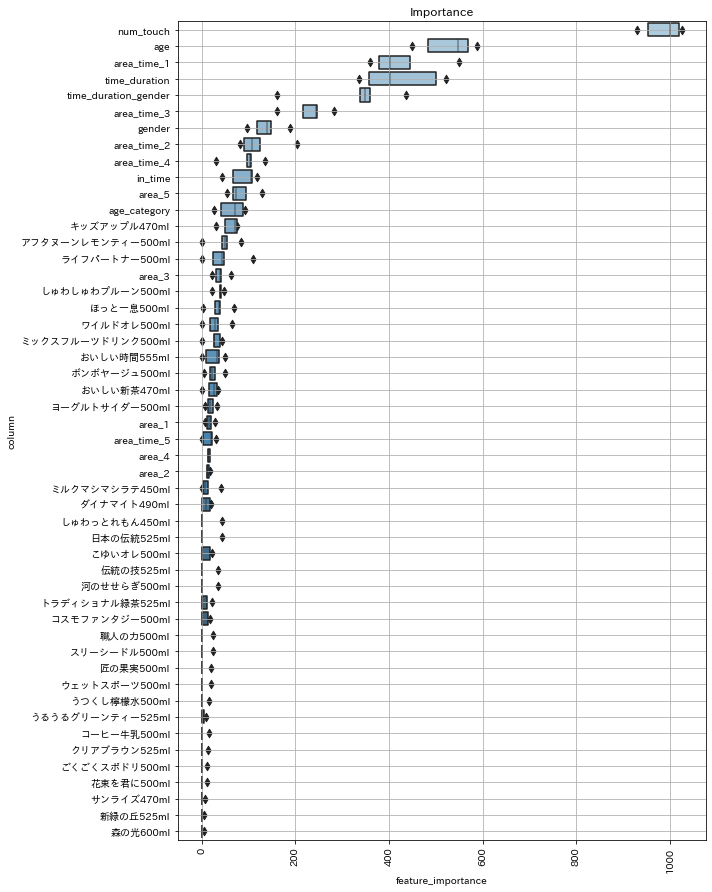

In [258]:
fig, ax = visualize_importance(models, train_x)

In [259]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

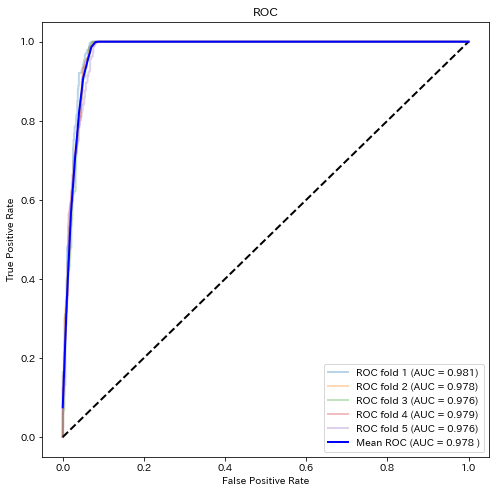

In [260]:
visulalize_roc(oof,CONFIG.fold)

In [261]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

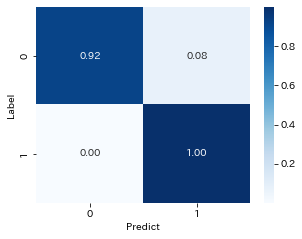

In [262]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [263]:
df_index = df_test_encoded.customer_id
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)

In [264]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [265]:
submission_pred

,customer_id,buy_proba
0,20201026-010006,1.0
1,20201026-010008,1.0
2,20201026-010011,1.0
3,20201026-010012,1.0
4,20201026-010018,1.0
...,...,...
4525,20201101-120039,0.0
4526,20201101-120046,0.0
4527,20201101-120051,1.0
4528,20201101-120052,1.0


In [266]:
submission_pred.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)